# Block Ciphers: AES and Analyses

## Introduction

Block ciphers are fundamental tools in symmetric-key cryptography, offering data security by encrypting fixed-size blocks of plaintext using a symmetric key. They are a type of product cipher, combining confusion (non-linear substitution) and diffusion (linear transformation) as defined by Shannon. Among these, the Advanced Encryption Standard (AES) is the most widely adopted, approved by NIST in 2001 as a replacement for DES [1]. AES is regarded for its strong security, efficiency and resistance to known cryptanalytic attacks. It operates on 128-bit blocks and supports key sizes of 128, 192, or 256 bits.

This report explores the transformation steps of AES encryption. We also evaluate the algorithm’s strength through Shannon's principles of confusion and diffusion, using bit-flipping, Hamming distance and Monte Carlo simulation to analyse AES’s resistance to differential attacks, [2]. Additionally, we examine how AES operates in different modes (ECB, CBC, CFB, OFB), each providing unique methods for securely encrypting data depending on use case requirements.

In [1]:
from aes import AES

from diffusion_confusion import flip_bit, hamming_distance
from diffusion_confusion import aes_diffusion, aes_confusion

In [4]:
# Debugging: Testing the Multiplicative Inverse in GF(2^8)
failed_count = 0
for byte in range(256):
    calculated_inverse = AES.galois_field_inverse(byte)
    standard_inverse = AES.inverse_s_box.index(byte) if byte in AES.inverse_s_box else 0

    if calculated_inverse != standard_inverse:
        print(f"Byte {hex(byte)}: Calculated Inverse={hex(calculated_inverse)} | Expected Inverse={hex(standard_inverse)}")
        failed_count += 1

print(f"\nTotal Mismatches (GF(2^8) Inverse): {failed_count} / 256")


Byte 0x0: Calculated Inverse=0x0 | Expected Inverse=0x63
Byte 0x1: Calculated Inverse=0x1 | Expected Inverse=0x7c
Byte 0x2: Calculated Inverse=0x8d | Expected Inverse=0x77
Byte 0x3: Calculated Inverse=0x5e | Expected Inverse=0x7b
Byte 0x4: Calculated Inverse=0x47 | Expected Inverse=0xf2
Byte 0x5: Calculated Inverse=0x1 | Expected Inverse=0x6b
Byte 0x6: Calculated Inverse=0x2f | Expected Inverse=0x6f
Byte 0x7: Calculated Inverse=0x51 | Expected Inverse=0xc5
Byte 0x8: Calculated Inverse=0x64 | Expected Inverse=0x30
Byte 0x9: Calculated Inverse=0x3f | Expected Inverse=0x1
Byte 0xa: Calculated Inverse=0x25 | Expected Inverse=0x67
Byte 0xb: Calculated Inverse=0x31 | Expected Inverse=0x2b
Byte 0xc: Calculated Inverse=0x14 | Expected Inverse=0xfe
Byte 0xd: Calculated Inverse=0x29 | Expected Inverse=0xd7
Byte 0xe: Calculated Inverse=0x45 | Expected Inverse=0xab
Byte 0xf: Calculated Inverse=0x78 | Expected Inverse=0x76
Byte 0x10: Calculated Inverse=0x31 | Expected Inverse=0xca
Byte 0x11: Calcul

In [3]:
# Standard AES Inverse S-Box for direct comparison
AES_inverse_s_box = [
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38,
    0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87,
    0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D,
    0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2,
    0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16,
    0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA,
    0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A,
    0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02,
    0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA
]

# Debugging: Compare Direct Calculation vs Standard Inverse S-Box
failed_count = 0
for byte in range(256):
    calculated = AES.inverse_byte_substitution_step(byte)  # Your calculation
    standard = AES_inverse_s_box[byte]

    if calculated != standard:
        print(f"Byte {hex(byte)}: Calculated={hex(calculated)} | Standard={hex(standard)}")
        failed_count += 1

print(f"\nTotal Mismatches: {failed_count} / 256")


Byte 0x0: Calculated=0x88 | Standard=0x52
Byte 0x1: Calculated=0xc6 | Standard=0x9
Byte 0x2: Calculated=0xaa | Standard=0x6a
Byte 0x3: Calculated=0x28 | Standard=0xd5
Byte 0x4: Calculated=0xf0 | Standard=0x30
Byte 0x5: Calculated=0xc6 | Standard=0x36
Byte 0x6: Calculated=0xd8 | Standard=0xa5
Byte 0x7: Calculated=0xb1 | Standard=0x38
Byte 0x8: Calculated=0xeb | Standard=0xbf
Byte 0x9: Calculated=0x3c | Standard=0x40
Byte 0xa: Calculated=0x36 | Standard=0xa3
Byte 0xb: Calculated=0xeb | Standard=0x9e
Byte 0xc: Calculated=0x55 | Standard=0x81
Byte 0xd: Calculated=0x7d | Standard=0xf3
Byte 0xe: Calculated=0x6c | Standard=0xd7
Byte 0xf: Calculated=0x44 | Standard=0xfb
Byte 0x10: Calculated=0xeb | Standard=0x7c
Byte 0x11: Calculated=0x6c | Standard=0xe3
Byte 0x12: Calculated=0x5f | Standard=0x39
Byte 0x13: Calculated=0x93 | Standard=0x82
Byte 0x14: Calculated=0xe1 | Standard=0x9b
Byte 0x15: Calculated=0xcc | Standard=0x2f
Byte 0x16: Calculated=0xdd | Standard=0xff
Byte 0x17: Calculated=0x77 |

IndexError: list index out of range

In [2]:
# Test 1: Known Plaintext and Ciphertext (NIST Test Vector)
plaintext = bytes.fromhex("3243f6a8885a308d313198a2e0370734")
key = bytes.fromhex("2b7e151628aed2a6abf7158809cf4f3c")
expected_ciphertext = bytes.fromhex("3925841d02dc09fbdc118597196a0b32")

aes = AES(key=key)

# Encrypt the plaintext
ciphertext = aes.encrypt(plaintext)
print("\nTest 1: Basic Known Plaintext and Ciphertext")
print("Ciphertext:", ciphertext.hex())
assert ciphertext == expected_ciphertext, "Encryption failed!"

# Decrypt the ciphertext
decrypted = aes.decrypt(ciphertext)
print("Decrypted:", decrypted.hex())
assert decrypted == plaintext, "Decryption failed!"



Test 1: Basic Known Plaintext and Ciphertext
Ciphertext: 3925841d02dc09fbdc118597196a0b32
Decrypted: 3243f6a8885a308d313198a2e0370734


In [4]:
type(AES(b'b\x07\xc2\xd3/\xcf\xfa\xdaSl\x81+\xa3Y\xcc\xd6').key_expansion())

list

In [6]:
AES(b'\xdc\xe0\xf5g\xdd\xf1\x8a\xab\xe9\x8d\x13\xa3\xc8Y]\x8b').partially_encrypt(b'rDi\x1f\n\x1b\xd1\x06l\x9ef%\x9at\x1cC', num_round=1)

b'"\t\xa9io\x8b\xf3\xab/\x00\x1d\x12L\x14\xfb\xf4'

## AES 

AES encryption consists of a series of rounds (10 for 128-bit keys). AES achieves security through a series of well-defined transformations on the plaintext and the key —substitution, permutation, mixing, key addition and expansion— applied in a repeated round structure. Before the first round, a key addition is performed in which the plaintext is XORed with the first round key. These transformations provide both non-linearity and mixing, critical to cryptographic strength. Each round involves:

In [2]:
key = bytes.fromhex("2b7e151628aed2a6abf7158809cf4f3c")
plaintext = bytes.fromhex("3243f6a8885a308d313198a2e0370734")

aes = AES(key)
round_keys = aes.key_expansion()

# Round key 0
print("Round Key 0:")
for row in round_keys[0]:
    print(" ".join(f"{b:02x}" for b in row))



print("\nRound Key 1:")
for row in round_keys[1]:
    print(" ".join(f"{b:02x}" for b in row))


Round Key 0:
2b 28 ab 09
7e ae f7 cf
15 d2 15 4f
16 a6 88 3c

Round Key 1:
a0 88 23 2a
fa 54 a3 6c
fe 2c 39 76
17 b1 39 05


In [3]:
state = [
    [0x01, 0x02, 0x03, 0x04],
    [0x05, 0x06, 0x07, 0x08],
    [0x09, 0x0a, 0x0b, 0x0c],
    [0x0d, 0x0e, 0x0f, 0x10],
]

round_key = [
    [0x10, 0x0f, 0x0e, 0x0d],
    [0x0c, 0x0b, 0x0a, 0x09],
    [0x08, 0x07, 0x06, 0x05],
    [0x04, 0x03, 0x02, 0x01],
]

result = AES.add_round_key(state, round_key)

for row in result:
    print(" ".join(f"{b:02x}" for b in row))


11 0d 0d 09
09 0d 0d 01
01 0d 0d 09
09 0d 0d 11


In [4]:
state = [
    [0x00, 0x01, 0x02, 0x03],
    [0x04, 0x05, 0x06, 0x07],
    [0x08, 0x09, 0x0a, 0x0b],
    [0x0c, 0x0d, 0x0e, 0x0f],
]

result = AES.byte_substitution(state)

for row in result:
    print(" ".join(f"{b:02x}" for b in row))


63 7c 77 7b
f2 6b 6f c5
30 01 67 2b
fe d7 ab 76


In [5]:
state = [
    [0x00, 0x01, 0x02, 0x03],
    [0x10, 0x11, 0x12, 0x13],
    [0x20, 0x21, 0x22, 0x23],
    [0x30, 0x31, 0x32, 0x33],
]

result = AES.shift_rows(state)

for row in result:
    print(" ".join(f"{b:02x}" for b in row))


00 01 02 03
11 12 13 10
22 23 20 21
33 30 31 32


In [6]:
state = [
    [0xdb, 0xf2, 0x01, 0xc6],
    [0x13, 0x0a, 0x01, 0xc6],
    [0x53, 0x22, 0x01, 0xc6],
    [0x45, 0x5c, 0x01, 0xc6],
]

result = AES.mix_column(state)

for row in result:
    print(" ".join(f"{b:02x}" for b in row))


8e 9f 01 c6
4d dc 01 c6
a1 58 01 c6
bc 9d 01 c6


In [7]:
state = [
    [0xdb, 0xf2, 0x01, 0xc6],
    [0x13, 0x0a, 0x01, 0xc6],
    [0x53, 0x22, 0x01, 0xc6],
    [0x45, 0x5c, 0x01, 0xc6]
]

expected = [
    [0x8e, 0x9f, 0x01, 0xc6],
    [0x4d, 0xdc, 0x01, 0xc6],
    [0xa1, 0x58, 0x01, 0xc6],
    [0xbc, 0x9d, 0x01, 0xc6]
]

result = AES.mix_column(state)

# Print results nicely
for r_row, e_row in zip(result, expected):
    print("Result:   ", " ".join(f"{b:02x}" for b in r_row))
    print("Expected: ", " ".join(f"{b:02x}" for b in e_row))
    print("Match?   ", r_row == e_row)
    print()


Result:    8e 9f 01 c6
Expected:  8e 9f 01 c6
Match?    True

Result:    4d dc 01 c6
Expected:  4d dc 01 c6
Match?    True

Result:    a1 58 01 c6
Expected:  a1 58 01 c6
Match?    True

Result:    bc 9d 01 c6
Expected:  bc 9d 01 c6
Match?    True



In [8]:
b = bytes(range(16))
m = AES.to_matrix(b)
print("Matrix:")
for row in m:
    print(" ".join(f"{x:02x}" for x in row))

print("\nBack to bytes:")
print(AES.to_bytes(m).hex())

print("\nOriginal:")
print(b.hex())

assert AES.to_bytes(m) == b

Matrix:
00 04 08 0c
01 05 09 0d
02 06 0a 0e
03 07 0b 0f

Back to bytes:
000102030405060708090a0b0c0d0e0f

Original:
000102030405060708090a0b0c0d0e0f


In [5]:
key = bytes.fromhex("2b7e151628aed2a6abf7158809cf4f3c")
plaintext = bytes.fromhex("3243f6a8885a308d313198a2e0370734")

aes = AES(key)
ciphertext = aes.encrypt(plaintext)

print("Ciphertext:", ciphertext.hex())
print("Expected:  ", "3925841d02dc09fbdc118597196a0b32")
print("✅ Match?  ", ciphertext.hex() == "3925841d02dc09fbdc118597196a0b32")

Ciphertext: 3925841d02dc09fbdc118597196a0b32
Expected:   3925841d02dc09fbdc118597196a0b32
✅ Match?   True


In [6]:
key = bytes.fromhex("000102030405060708090a0b0c0d0e0f")
plaintext = bytes.fromhex("00112233445566778899aabbccddeeff")
expected_ciphertext = "69c4e0d86a7b0430d8cdb78070b4c55a"

"""key = bytes.fromhex("00000000000000000000000000000000")
plaintext = bytes.fromhex("00000000000000000000000000000000")
expected_ciphertext = "66e94bd4ef8a2c3b884cfa59ca342b2e"""

"""key = bytes.fromhex("ffffffffffffffffffffffffffffffff")
plaintext = bytes.fromhex("ffffffffffffffffffffffffffffffff")
expected_ciphertext = "a1f6258c877d5fcd8964484538bfc92c"""

"""key = bytes.fromhex("2b7e151628aed2a6abf7158809cf4f3c")
plaintext = bytes.fromhex("3243f6a8885a308d313198a2e0370734")
expected_ciphertext = "3925841d02dc09fbdc118597196a0b32"""

aes = AES(key)
ciphertext = aes.encrypt(plaintext)

print("Result:   ", ciphertext.hex())
print("Expected: ", expected_ciphertext)
print("Match?    ", ciphertext.hex() == expected_ciphertext)

Result:    69c4e0d86a7b0430d8cdb78070b4c55a
Expected:  69c4e0d86a7b0430d8cdb78070b4c55a
Match?     True


In [21]:
for round_idx, matrix in enumerate(aes.key_expansion()):
    print(f"Round {round_idx}:")
    for row in matrix:
        print(" ".join(f"{b:02x}" for b in row))


Round 0:
ff ff ff ff
ff ff ff ff
ff ff ff ff
ff ff ff ff
Round 1:
e8 17 e8 17
e9 16 e9 16
e9 16 e9 16
e9 16 e9 16
Round 2:
ad ba 52 45
ae b8 51 47
ae b8 51 47
19 0f e6 f0
Round 3:
09 b3 e1 a4
0e b6 e7 a0
22 9a cb 8c
77 78 9e 6e
Round 4:
e1 52 b3 17
6a dc 3b 9b
bd 27 ec 60
3e 46 d8 b6
Round 5:
e5 b7 04 13
ba 66 5d c6
f3 d4 38 58
ce 88 50 e6
Round 6:
71 c6 c2 d1
d0 b6 eb 2d
7d a9 91 c9
b3 3b 6b 8d
Round 7:
e9 2f ed 3c
0d bb 50 7d
20 89 18 d1
8d b6 dd 50
Round 8:
96 b9 54 68
33 88 d8 a5
73 fa e2 33
66 d0 0d 5d
Round 9:
8b 32 66 0e
f0 78 a0 05
3f c5 27 14
23 f3 fe a3
Round 10:
d6 e4 82 8c
0a 72 d2 d7
35 f0 d7 c3
88 7b 85 26


In [4]:
input_bytes = bytes(range(16))
aes = AES(key)
AES.to_bytes(AES.to_matrix(input_bytes))

b'\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f'

### Add Round Key

The AddRoundKey transformation is the first and last step in the AES round structure. It performs a bitwise XOR between the current 4x4 state matrix and a round-specific subkey generated through key expansion. (This step is simple yet vital, as it introduces the key-dependent variation at every round, ensuring that the encryption is tied to the secret key.) This step ensures that the ciphertext is dependent on the secret key from the very beginning,. Since XOR is its own inverse, this transformation is easily reversible during decryption [1].
It is important to note that the AddRoundKey step is positioned at the beginning because any transformations before it (or after the final AddRoundKey) can be trivially inverted without knowing the key. This means they do not contribute to the security of the cipher. 

### Substitution Bytes

The invertible SubBytes operation provides non-linearity to the cipher by substituting each byte of the state using a substitution box (S-box). This S-box is constructed using the multiplicative inverse over GF(2^8), followed by an affine transformation. It enhances resistance against linear and differential cryptanalysis by ensuring that small changes in input create unpredictable output differences, providing confusion [3].

### Shift Rows

ShiftRows is a permutation step that cyclically shifts each row of the state matrix to the left by a certain number of bytes: the second row by 1, the third by 2, and the fourth by 3 positions, ensuring confusion. This operation spreads the byte positions across columns, contributing to diffusion by ensuring that the effect of a single byte affects multiple columns over rounds [4].

### Mix Columns

The MixColumns step transforms each column of the state matrix using polynomial multiplication in GF(2^8) with a fixed matrix. It blends the four bytes in each column, creating dependency between them. This step is essential for diffusion, ensuring that a change in one byte impacts all four bytes in the column [1]. It is skipped in the final round to simplify decryption.

The **MixColumns** step transforms each column of the state matrix using a fixed mathematical transformation over \( GF(2^8) \). Each column of four bytes is treated as a vector and is multiplied by a constant 4x4 matrix, mixing the bytes within the column. This process ensures that a change in one byte affects all four bytes in that column, providing strong diffusion. It is skipped in the final round to maintain efficient decryption without weakening security [1].


### Key Expansion

Key Expansion (also known as the key schedule) takes the original cipher key and expands it into an array of round keys. This process uses byte substitution, rotation, and the addition of round constants to ensure that each round key is unique and non-linearly related to the original key. For AES-128, 11 round keys are generated: one for the initial key addition and ten for the rounds [5].

The AES-128 Key Expansion (Key Schedule) generates 11 round keys, each consisting of four 32-bit words (44 words in total) from the initial 128-bit key. The first four words are directly taken from the original key. Subsequent words are generated iteratively using a process that introduces non-linearity and key dependence. Specifically, every fourth word undergoes a transformation known as the 
g-function, which includes a cyclic left shift, byte substitution using the S-Box, and an XOR with a round-dependent constant (RC). Each new word is then derived by XORing this transformed word with the word four positions earlier. This process ensures that each round of AES uses a unique 128-bit round key, with the first key used in the initial AddRoundKey step and the remaining 10 for the main encryption rounds.

### Encryption

The encryption for 128-bit key process consists of:

*Initial AddRoundKey

*9 rounds of: SubBytes → ShiftRows → MixColumns → AddRoundKey

*Final round: SubBytes → ShiftRows → AddRoundKey (no MixColumns)

Each transformation plays a critical role in strengthening the cipher against various attacks, from linear cryptanalysis to differential cryptanalysis [4].
Each transformation plays a critical role in ensuring the cipher's security by introducing non-linearity, diffusion, and key dependence, effectively defending against attacks such as linear and differential cryptanalysis [4]

## AES Diffusion and Confusion

Claude Shannon emphasized two principles for secure cipher design: confusion, which hides the relationship between ciphertext and key, and diffusion, which spreads plaintext information across the ciphertext [2]. To test diffusion, a single-bit flip was introduced in the plaintext. The number of differing bits in the ciphertext was measured using Hamming distance, which is the number of differing bits between two binary strings of equal length. A high Hamming distance indicates good diffusion, as the effect of the bit flip propagates through the entire block. Likewise, confusion was assessed by modifying a single bit in the key, observing how this change altered the ciphertext. 

change here AES demonstrated high confusion, as even minor key changes significantly altered the output [6].

In [17]:
import matplotlib.pyplot as plt

def run_monte_carlo(function, num_rounds=None, num_trials=1000):
    distances = []
    for i in range(num_trials):
        distance = function(num_rounds)
        distances.append(distance)
    return distances

In [ ]:
diffusion_results = run_monte_carlo(aes_diffusion, num_rounds=1, num_trials=1000)
confusion_results = run_monte_carlo(aes_confusion, num_rounds=10, num_trials=1000)

Diffusion - Mean: 64.049, Std: 5.722988642309192


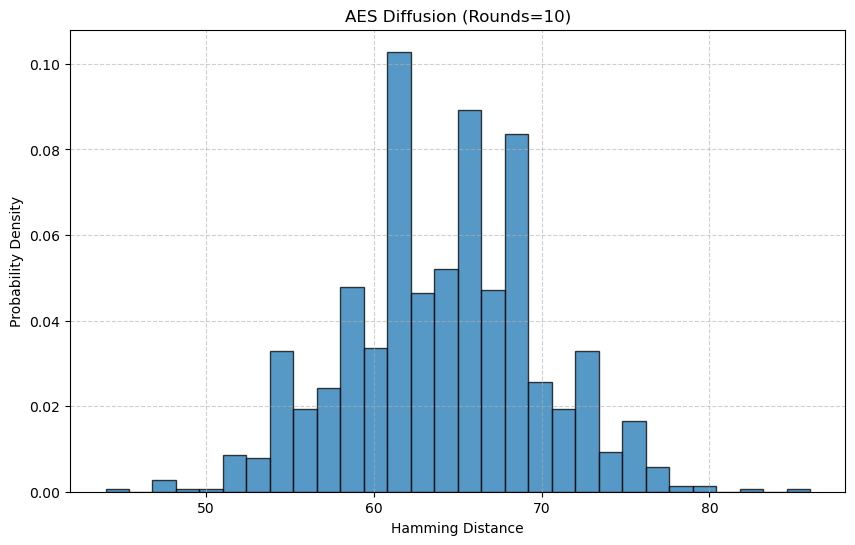

Confusion - Mean: 64.125, Std: 5.793218017647877


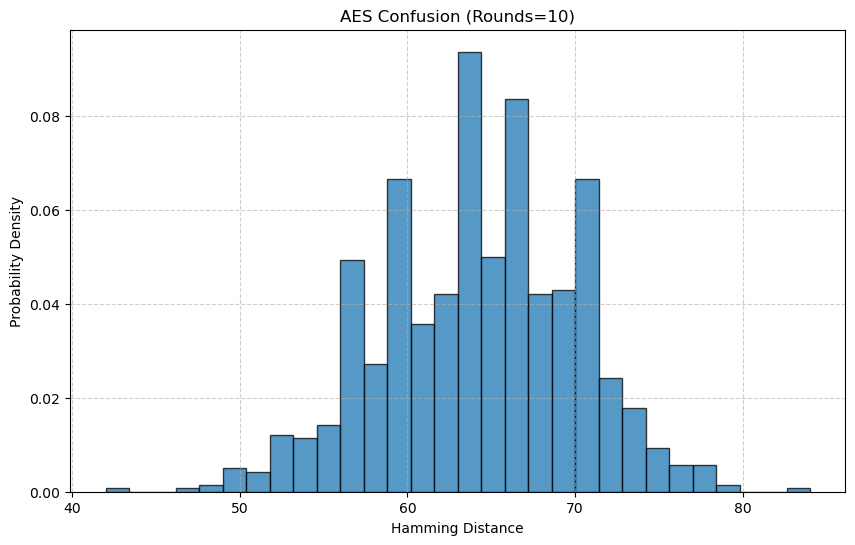

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def run_monte_carlo(function, num_rounds=None, num_trials=1000):
    distances = []
    for _ in range(num_trials):
        distance = function(num_rounds)
        distances.append(distance)
    
    return distances

def plot_distribution(distances, title):
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=30, alpha=0.75, edgecolor='black', density=True)
    plt.title(title)
    plt.xlabel("Hamming Distance")
    plt.ylabel("Probability Density")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Run Monte Carlo Simulation for Diffusion and Confusion
num_rounds = 10  # Change this for different rounds
num_trials = 1000

# Diffusion Analysis
diffusion_distances = run_monte_carlo(aes_diffusion, num_rounds, num_trials)
print(f"Diffusion - Mean: {np.mean(diffusion_distances)}, Std: {np.std(diffusion_distances)}")
plot_distribution(diffusion_distances, f"AES Diffusion (Rounds={num_rounds})")

# Confusion Analysis
confusion_distances = run_monte_carlo(aes_confusion, num_rounds, num_trials)
print(f"Confusion - Mean: {np.mean(confusion_distances)}, Std: {np.std(confusion_distances)}")
plot_distribution(confusion_distances, f"AES Confusion (Rounds={num_rounds})")


### Monte Carlo Simulation

Monte Carlo Simulation (MCS) is a statistical technique that uses random sampling to approximate the probability distributions of outcomes, by performing many trial runs. It is widely used in cryptography to evaluate how secure a cipher is by analyzing its behavior under various conditions. 

We conducted a Monte Carlo simulation with 1,000 trials for each round of AES (from 1 to 10 rounds) to analyze the confusion and diffusion properties of the cipher. In each trial, the Hamming distance was measured between ciphertexts under two scenarios: one where the plaintext differed by a single bit (diffusion) and another where the key differed by a single bit (confusion). The resulting distributions of Hamming distances for each round are shown in the histograms above. 

#### **Diffusion Results:**
- **Initial Round (1):** Diffusion is minimal, with an average Hamming distance of 16.1. This is expected since the impact of a single bit change in the plaintext has not yet fully propagated through the cipher's transformations.
- **Subsequent Rounds (2-10):** The Hamming distance rapidly increases to around 64 by the second round and remains stable in the following rounds, with a standard deviation of approximately 5.7. This indicates that the plaintext changes are spreading effectively, creating a complex dependency between the input and output.

#### **Confusion Results:**
- **Initial Round (1):** Confusion is limited, with a mean Hamming distance of 21.4, indicating that the relationship between the key and ciphertext is not yet fully complex.
- **Subsequent Rounds (2-10):** The Hamming distance quickly aligns with that of diffusion, stabilizing around 64 with a similar standard deviation. This demonstrates that a single-bit change in the key has a strong, unpredictable impact on the ciphertext by the second round.

#### **General Remarks:**
- The rapid increase in Hamming distance within the first two rounds shows that AES quickly achieves strong confusion and diffusion properties, which are critical for its security.
- The stabilization around 64 for both properties aligns with the theoretical expectation for a 128-bit block cipher, where on average, half of the bits (64 out of 128) should differ due to a single-bit change.
- The slight variation in standard deviation across rounds is expected due to the probabilistic nature of the Monte Carlo simulation but remains within a narrow range.

Diffusion (Rounds=1) - Mean: 16.105, Std: 3.901278636549817
Confusion (Rounds=1) - Mean: 21.367, Std: 6.199702492862057
Diffusion (Rounds=2) - Mean: 64.508, Std: 7.917066123255508
Confusion (Rounds=2) - Mean: 64.144, Std: 6.2057444356015825
Diffusion (Rounds=3) - Mean: 64.108, Std: 5.659181566269101
Confusion (Rounds=3) - Mean: 64.087, Std: 5.8061545794096805
Diffusion (Rounds=4) - Mean: 63.996, Std: 5.63364748630938
Confusion (Rounds=4) - Mean: 63.891, Std: 5.591700904018383
Diffusion (Rounds=5) - Mean: 63.594, Std: 5.789919170420258
Confusion (Rounds=5) - Mean: 63.979, Std: 5.614495435922983
Diffusion (Rounds=6) - Mean: 63.876, Std: 5.67491180548209
Confusion (Rounds=6) - Mean: 64.064, Std: 5.722753183564708
Diffusion (Rounds=7) - Mean: 64.318, Std: 5.741504680830627
Confusion (Rounds=7) - Mean: 64.069, Std: 5.680513973224606
Diffusion (Rounds=8) - Mean: 63.787, Std: 5.336818434235888
Confusion (Rounds=8) - Mean: 64.069, Std: 5.65740567751686
Diffusion (Rounds=9) - Mean: 63.772, Std:

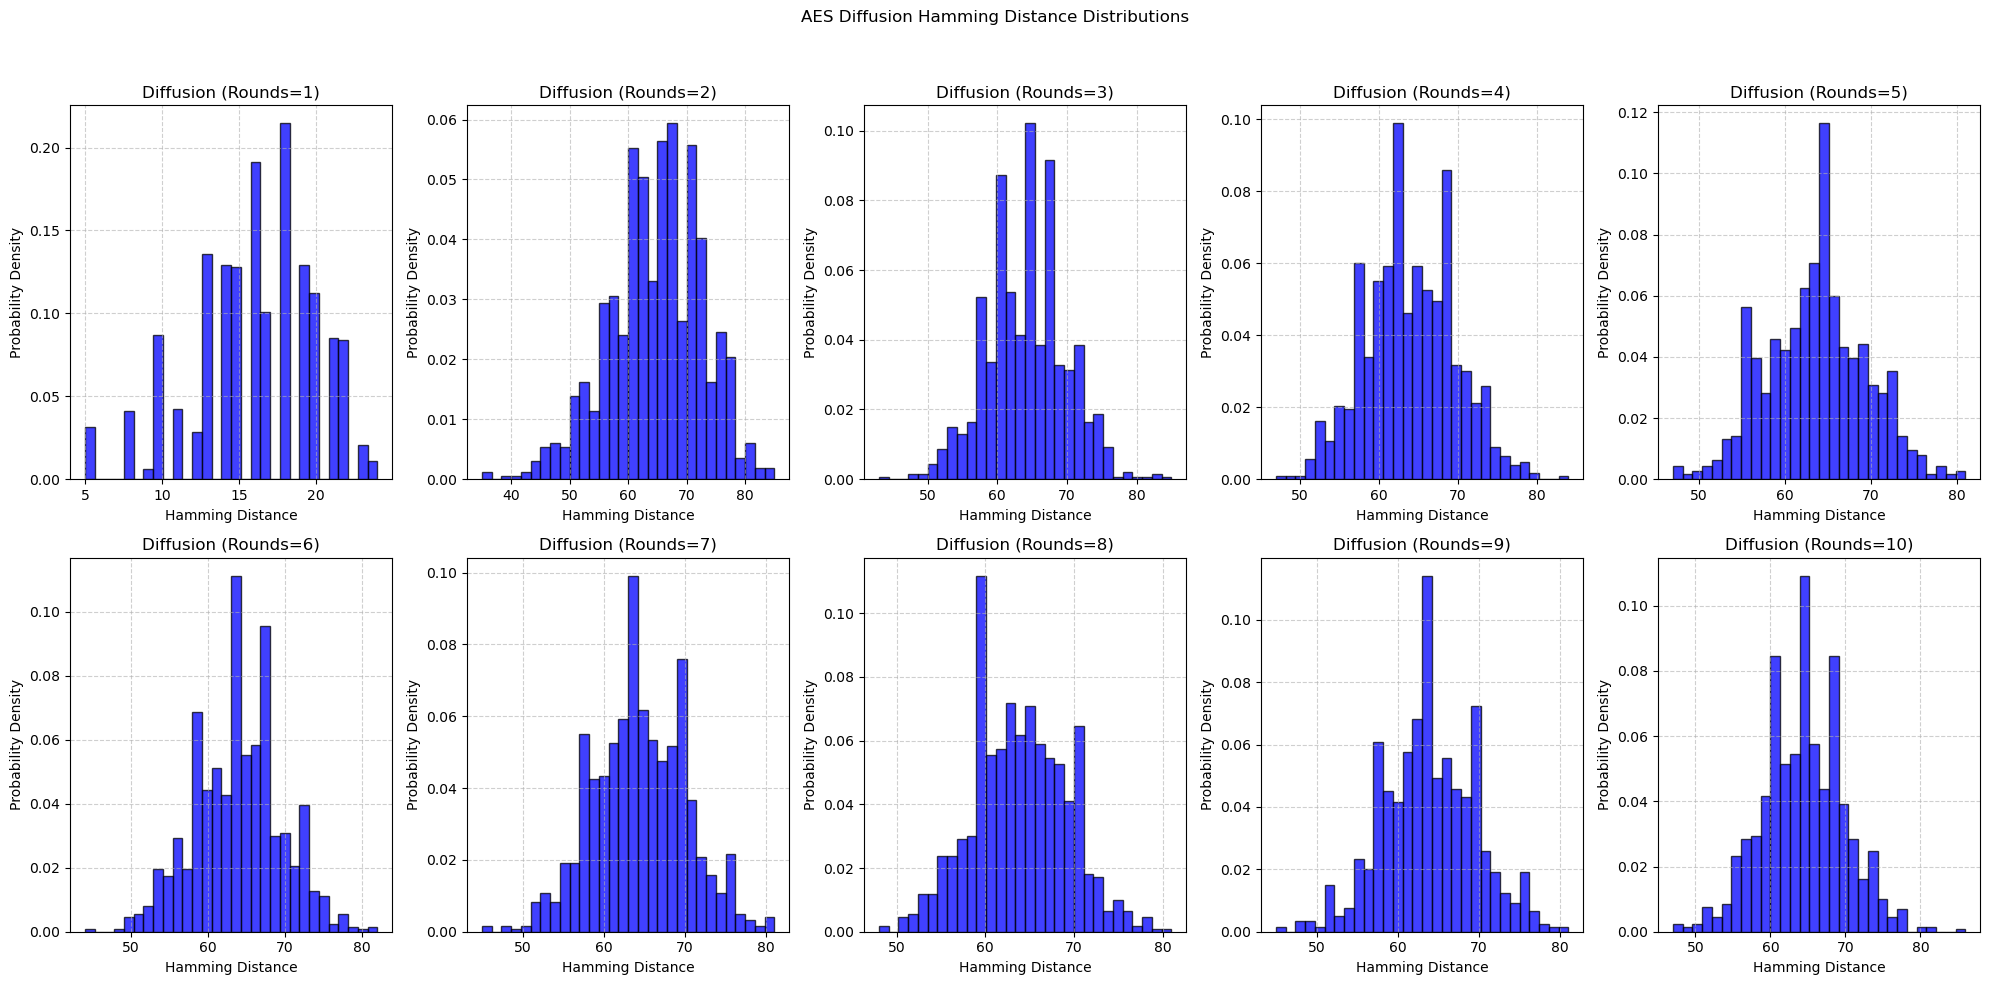

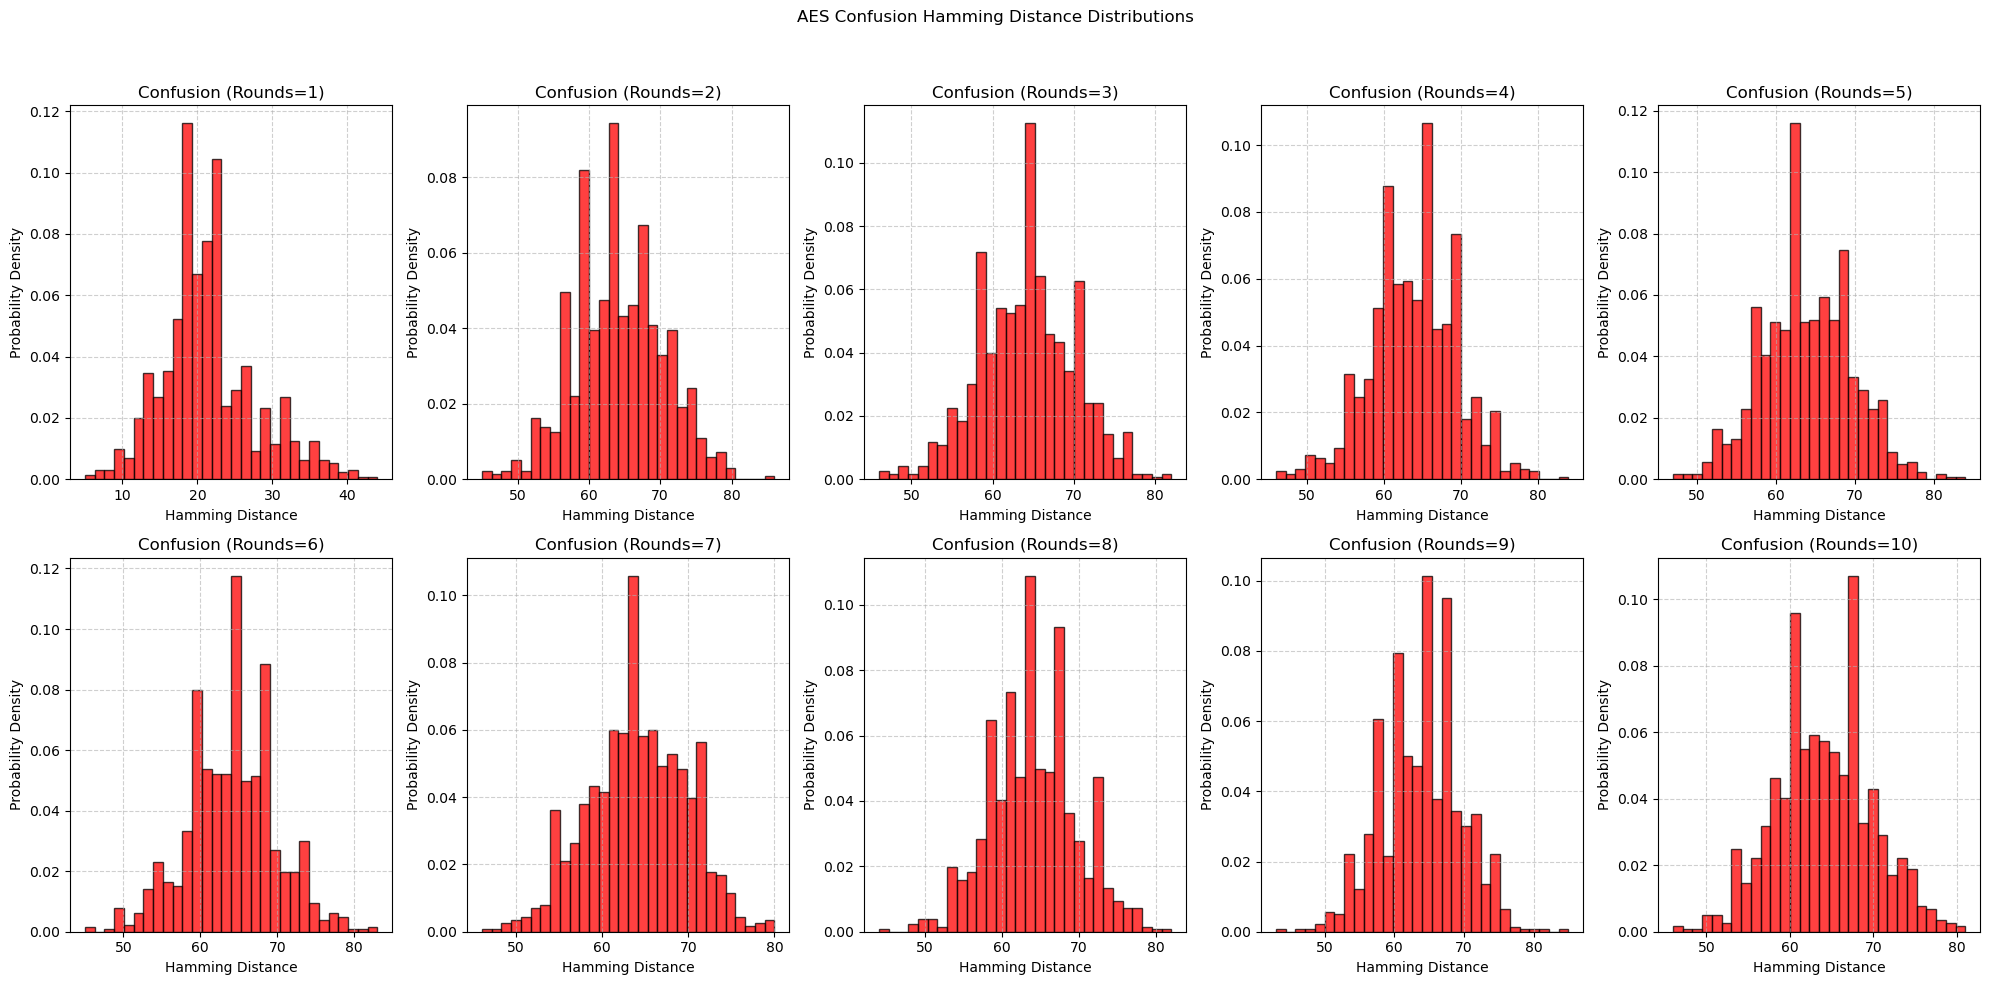

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Monte Carlo Simulation Function
def run_monte_carlo(function, num_rounds=None, num_trials=1000):
    distances = []
    for _ in range(num_trials):
        distance = function(num_rounds)
        distances.append(distance)
    
    return distances

# Plotting Function for Diffusion
def plot_diffusion(distances_list):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle("AES Diffusion Hamming Distance Distributions")

    for num_rounds in range(1, 11):
        ax = axes[(num_rounds - 1) // 5, (num_rounds - 1) % 5]
        distances = distances_list[num_rounds - 1]
        ax.hist(distances, bins=30, alpha=0.75, edgecolor='black', color='blue', density=True)
        ax.set_title(f"Diffusion (Rounds={num_rounds})")
        ax.set_xlabel("Hamming Distance")
        ax.set_ylabel("Probability Density")
        ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plotting Function for Confusion
def plot_confusion(distances_list):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle("AES Confusion Hamming Distance Distributions")

    for num_rounds in range(1, 11):
        ax = axes[(num_rounds - 1) // 5, (num_rounds - 1) % 5]
        distances = distances_list[num_rounds - 1]
        ax.hist(distances, bins=30, alpha=0.75, edgecolor='black', color='red', density=True)
        ax.set_title(f"Confusion (Rounds={num_rounds})")
        ax.set_xlabel("Hamming Distance")
        ax.set_ylabel("Probability Density")
        ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Monte Carlo Simulation for Diffusion and Confusion (All Rounds)
num_trials = 1000  # Adjust for faster/slower simulation

# Collecting results in lists
diffusion_results = []
confusion_results = []

for num_rounds in range(1, 11):
    # Diffusion Analysis
    diffusion_distances = run_monte_carlo(aes_diffusion, num_rounds, num_trials)
    diffusion_results.append(diffusion_distances)
    print(f"Diffusion (Rounds={num_rounds}) - Mean: {np.mean(diffusion_distances)}, Std: {np.std(diffusion_distances)}")

    # Confusion Analysis
    confusion_distances = run_monte_carlo(aes_confusion, num_rounds, num_trials)
    confusion_results.append(confusion_distances)
    print(f"Confusion (Rounds={num_rounds}) - Mean: {np.mean(confusion_distances)}, Std: {np.std(confusion_distances)}")

# Save the results to a pickle file
with open("aes_results.pkl", "wb") as f:
    pickle.dump({"diffusion": diffusion_results, "confusion": confusion_results}, f)
print("Results saved to aes_results.pkl.")

# Plot the results
plot_diffusion(diffusion_results)
plot_confusion(confusion_results)



In [5]:
import pickle

# Assuming you already have your calculated results:
diffusion_results = [
    diffusion_distances_round1,  # List of distances for round 1
    diffusion_distances_round2,  # List of distances for round 2
    diffusion_distances_round3,  # List of distances for round 3
    # ... add all the way up to round 10
]

confusion_results = [
    confusion_distances_round1,  # List of distances for round 1
    confusion_distances_round2,  # List of distances for round 2
    confusion_distances_round3,  # List of distances for round 3
    # ... add all the way up to round 10
]

# Save these results to a pickle file
with open("aes_results.pkl", "wb") as f:
    pickle.dump({"diffusion": diffusion_results, "confusion": confusion_results}, f)
print("Results saved to aes_results.pkl.")


NameError: name 'diffusion_distances_round1' is not defined

## Bonus: AES Decryption and the BlockCipher Class

### Decryption

### The BlockCipher Class

## Conclusion

AES remains a gold standard in symmetric encryption due to its elegant combination of speed, security, and simplicity. Its structured design incorporating non-linearity (SubBytes), mixing (MixColumns), and key variation (Key Expansion) makes it robust against classical and modern attacks. By analyzing diffusion and confusion empirically, we confirmed that AES effectively masks both the plaintext and key within the ciphertext, satisfying core cryptographic goals.

## References

[1] National Institute of Standards and Technology (NIST). FIPS PUB 197: Advanced Encryption Standard (AES). 2001.

[2] Shannon C. Communication theory of secrecy systems. Bell System Technical Journal. 1949;28(4):656–715.

[3] Daemen J, Rijmen V. The Design of Rijndael: AES—The Advanced Encryption Standard. Springer-Verlag; 2002.

[4] Stallings W. Cryptography and Network Security: Principles and Practice. 8th ed. Pearson; 2023.

[5] National Institute of Standards and Technology. AES Known Answer Test Vectors. 2001.

[6] Paar C, Pelzl J. Understanding Cryptography: A Textbook for Students and Practitioners. 2nd ed. Springer; 2018.